### This notebook enables to detect those cases in which there is no Site coordinates reported, but the Dec/Inc and Plat/Plon coordinates allow its calculation

In [103]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from scipy import optimize
import seaborn as sns

from scripts.auxiliar import get_files_in_directory, spherical2cartesian, cartesian2spherical, GCD_cartesian
pd.set_option('display.max_columns', None)

### Displaying all the csv file in the vgp_database folder

In [104]:
current_path = os.getcwd()
data_path_VGP = current_path + '/vgp_database'
files_names = get_files_in_directory(data_path_VGP)

csv_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.csv')] #consider just *csv files
xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')] #consider just *csv files
paths = [file for file in files_names if file.endswith('.xlsx')] 
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})
df_files[['name_xlsx']]

,name_xlsx
0,Absaroka_volcanics
1,Beaver_River_intrusions
2,Bighorn_Basin_sediments
3,Bishop_tuff
4,Bitterroot_Dome_intrusions
5,Central_Mexico_Plio-Pleistocene
6,Clear_Lake_volcanic_field
7,Coso_Range_volcanics
8,Dinan_Bay_lavas
9,Eastern_Alkaline_Province


### Select by index the file you want to display

In [118]:
index = 0

#### Separate the *.csv file into two different DFs, `df_vgps` and `df_poles`. Note: the csv has to be separated by just one blank row
- On the one hand, we have the poles tagged by different criterias.
- On the other hand, we have a DF for every single direction/vgp/site resported by the original paper

In [119]:
df = pd.read_excel(df_files['path'][index]) #, skip_blank_lines=True

In [120]:
df_poles = pd.read_excel(df_files['path'][index], 
                         skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,
                         nrows  = df[df.isnull().all(1)].index[1] -3)

df_vgps = pd.read_excel(df_files['path'][index], 
                        skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)

#cast columns
df_vgps = df_vgps.astype({'in_study_pole': int,
                          "slat":float, "slon":float, "dec":float, "inc":float,
                          "VGP_lat":float, "VGP_lon":float
                         })
df_poles = df_poles.astype({'N': int,
                          "slat":float, "slon":float, "dec":float, "inc":float,
                          "Plat":float, "Plon":float})

In [121]:
df_vgps.head()

,name,fm./loc.,slat,slon,n,dec,inc,k,alpha95,f_corr,VGP_lat,VGP_lon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,demag,struc_cont,rot_area,polarity,strat_group,ordering,synch_unit,in_study_pole,rej_crit,pmag_ref,age_ref,pmag_comments,age_comments,Unnamed: 38
0,6.0,Sylvan Pass,NaN,NaN,5.0,343.4,64.3,58.3,8.2,NaN,78.2,-186.7,NaN,NaN,NaN,NaN,NaN,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,NaN,NaN,NaN,N,1.0,1.0,0.0,1,NaN,Shive and Pruss (1977),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,NaN
1,7*,Sylvan Pass,NaN,NaN,4.0,336.7,-87.2,9.0,23.3,NaN,39.3,-107.1,NaN,NaN,NaN,NaN,NaN,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,NaN,NaN,NaN,I,1.0,2.0,0.0,0,3,Shive and Pruss (1977),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,NaN
2,8.0,Sylvan Pass,NaN,NaN,5.0,121.8,-73.1,165.6,4.9,NaN,52.6,-156.7,NaN,NaN,NaN,NaN,NaN,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,NaN,NaN,NaN,R,1.0,3.0,0.0,1,NaN,Shive and Pruss (1977),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,NaN
3,33*,Jim Mountain to Trout Peak,NaN,NaN,3.0,91.0,74.1,1.3,NaN,NaN,37.2,-71.1,NaN,NaN,NaN,NaN,NaN,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,NaN,NaN,NaN,N,2.0,1.0,0.0,0,3,Shive and Pruss (1977),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,NaN
4,34*,Jim Mountain to Trout Peak,NaN,NaN,3.0,60.4,48.8,6.6,31.4,NaN,40.8,-23.5,NaN,NaN,NaN,NaN,NaN,48.0,NaN,49.0,NaN,uniform,igneous,volcanic,basalt,NaN,NaN,NaN,N,2.0,2.0,0.0,0,3,Shive and Pruss (1977),Harlan and Morgan (2010),NaN,crude age range provided by Harlan and Morgan ...,NaN


## We proceed to populate the VGP DataFrame (`df_vgps`) following different criteria
 - If the site coordinates are reported, we keep them
 - If the site coordinates are not reported, but we have VGP_lat/VGP_lon and dec/inc, we calculate them
 - Otherwise, we keep NaN

In [122]:
# Do the following for the entries with missing slat and slong
df_vgps['Calculate_site'] = df_vgps.apply(lambda row: True if (np.isnan(row.slat) & (~np.isnan(row.VGP_lat) | ~np.isnan(row.dec))) else True, axis =1)

In [123]:
def get_site_coordinates(D, I, Plat, Plon):
    '''
    The following function retrives Site coordinates from Dec/Inc and Plat/Plom
    NOTE! there are always two possible solutions so the outcome is a list in the form [[Slat1, Slon1],[Slat2, Slon2]]
    '''
    paleolat = np.degrees(np.arctan(0.5 * np.tan(np.radians(I))))
    colatitude = 90 - paleolat
    beta = np.degrees(np.arcsin((np.sin(np.radians(colatitude)) * np.sin(np.radians(D))) / (np.cos(np.radians(Plat)))))
    
    def guess(Slat):
        guess = np.arcsin(np.sin(np.radians(Slat)) * np.cos(np.radians(colatitude)) +
                     np.cos(np.radians(Slat)) * np.sin(np.radians(colatitude)) * np.cos(np.radians(D))) - np.radians(Plat)
        return np.degrees(guess)

    sol = optimize.root(guess, x0 = [-90,90],  method='hybr')
    
    res = []
    
    for i in sol.x:
                
        if np.cos(np.radians(colatitude)) > np.sin(np.radians(i)) * np.sin(np.radians(Plat)):            
            Slon = (Plon - beta) % 360.
        else:
            Slon = (Plon - 180 + beta) % 360.
        
        res.append([i,Slon])
    
    return res 

In [124]:
df_vgps['slat_1'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[0][0] if (row.Calculate_site == True) else row.slat, axis =1) # where 9999 is a function to be built
df_vgps['slon_1'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[0][1] if (row.Calculate_site == True) else row.slon, axis =1) # where 9999 is a function to be built
df_vgps['slat_2'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[1][0] if (row.Calculate_site == True) else row.slat, axis =1) # where 9999 is a function to be built
df_vgps['slon_2'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[1][1] if (row.Calculate_site == True) else row.slon, axis =1) # where 9999 is a function to be built

In [125]:
df_vgps[['name','slat_1','slon_1','slat_2','slon_2',]]

,name,slat_1,slon_1,slat_2,slon_2
0,6.0,44.347882,248.954425,50.274058,277.645575
1,7*,-135.531568,70.047730,-34.201199,70.047730
2,8.0,-80.043790,69.905362,279.956210,69.905362
3,33*,-9223.521324,250.483666,3284.660658,250.483666
4,34*,53.920402,242.365581,53.920402,242.365581
...,...,...,...,...,...
134,I6,-130.802695,85.868782,224.991546,68.931218
135,I7,-123.243692,103.186186,225.075232,69.413814
136,I8,-104.862171,175.013550,219.789151,1.386450
137,Independence stock mean,-129.338457,94.741691,225.066295,69.058309


### visualizing the outcome

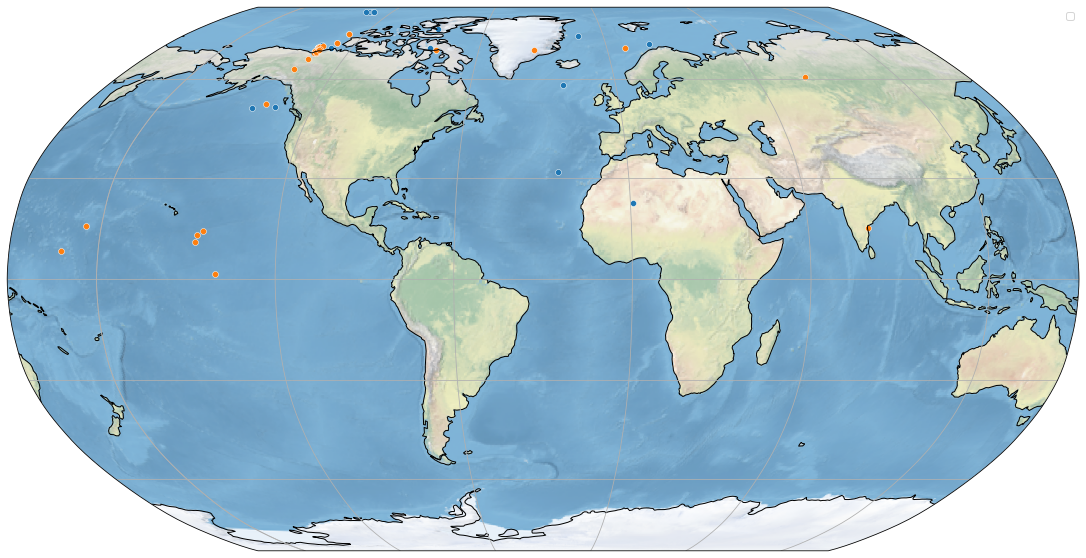

In [126]:
fig = plt.figure(figsize=(20,10))

proj = ccrs.Robinson(central_longitude=-30)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = df_vgps['slat_1'], y = df_vgps['slon_1'], transform = ccrs.PlateCarree())
sns.scatterplot(x = df_vgps['slat_2'], y = df_vgps['slon_2'], transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()

### Iterate through every file

In [129]:
for _,i in df_files.iterrows():
    
    
    df = pd.read_excel(i['path']) #, skip_blank_lines=True
    
    df_poles = pd.read_excel(i['path'],
                             skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,             
                             nrows  = df[df.isnull().all(1)].index[1] -3)

    df_vgps = pd.read_excel(i['path'], 
                            skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)
    print(df_vgps)
    #cast columns
    df_vgps = df_vgps.astype({'in_study_pole': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "VGP_lat":float, "VGP_lon":float})
    df_poles = df_poles.astype({'N': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "Plat":float, "Plon":float})

                        name                    fm./loc.     slat      slon  \
0                        6.0                 Sylvan Pass      NaN       NaN   
1                         7*                 Sylvan Pass      NaN       NaN   
2                        8.0                 Sylvan Pass      NaN       NaN   
3                        33*  Jim Mountain to Trout Peak      NaN       NaN   
4                        34*  Jim Mountain to Trout Peak      NaN       NaN   
..                       ...                         ...      ...       ...   
134                       I6          Independence stock  45.2169 -110.2200   
135                       I7          Independence stock  45.2133 -110.2183   
136                       I8          Independence stock  45.2147 -110.2164   
137  Independence stock mean          Independence stock      NaN       NaN   
138                       I5               Andesite plug  45.2178 -110.2250   

        n    dec   inc      k  alpha95  f_corr  VGP